# CelebA - EDA:

Installed package img2vec_pytorch to run preprocessing.py to get imgs pre-processed by a pre-trained resnet-18 to get an input vector (that represents the image) of size 512.

In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from centralized_training import Model, train, test
from sklearn.model_selection import train_test_split
import torch
#from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from myFL import Simulation

## Attributes:

In [2]:
attr_path = 'data_celebA/celeba/Anno/list_attr_celeba_comma_separated.txt'
attr_csv = pd.read_csv(attr_path, sep=' ').drop('Unnamed: 41', axis=1, inplace=False)

In [3]:
for col in attr_csv.columns[1:]:
    print(attr_csv[col].value_counts(normalize=True))

5_o_Clock_Shadow
0    0.888864
1    0.111136
Name: proportion, dtype: float64
Arched_Eyebrows
0    0.733019
1    0.266981
Name: proportion, dtype: float64
Attractive
1    0.512505
0    0.487495
Name: proportion, dtype: float64
Bags_Under_Eyes
0    0.795428
1    0.204572
Name: proportion, dtype: float64
Bald
0    0.977557
1    0.022443
Name: proportion, dtype: float64
Bangs
0    0.848425
1    0.151575
Name: proportion, dtype: float64
Big_Lips
0    0.759204
1    0.240796
Name: proportion, dtype: float64
Big_Nose
0    0.765468
1    0.234532
Name: proportion, dtype: float64
Black_Hair
0    0.760749
1    0.239251
Name: proportion, dtype: float64
Blond_Hair
0    0.852008
1    0.147992
Name: proportion, dtype: float64
Blurry
0    0.949101
1    0.050899
Name: proportion, dtype: float64
Brown_Hair
0    0.794806
1    0.205194
Name: proportion, dtype: float64
Bushy_Eyebrows
0    0.857832
1    0.142168
Name: proportion, dtype: float64
Chubby
0    0.942433
1    0.057567
Name: proportion, dtype: flo

In [4]:
col_index = dict(zip(np.arange(0, 40), attr_csv.columns[1:]))

<Axes: >

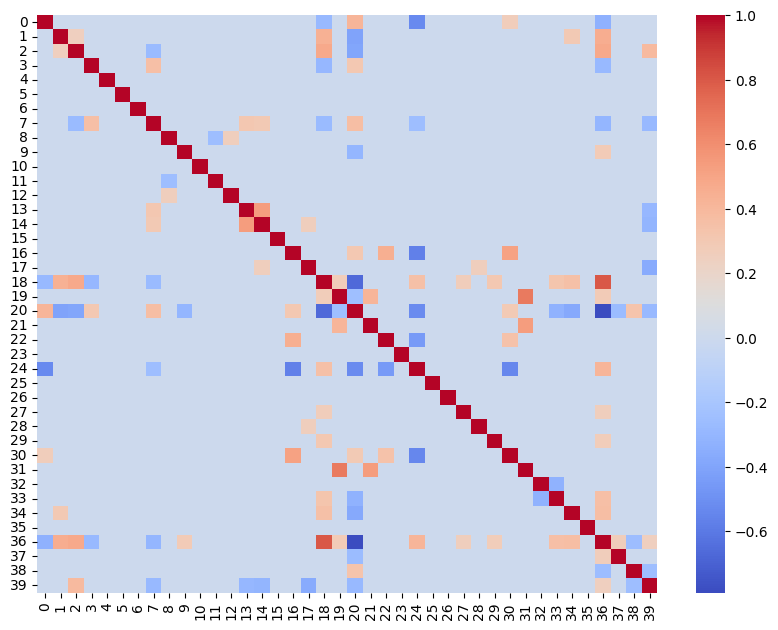

In [5]:
corr = attr_csv.drop('index', axis=1, inplace=False).corr()
corr.columns = np.arange(0, len(corr.columns))
corr.index = np.arange(0, len(corr.index))
croped_corr = corr.apply(lambda x: [y if y >= 0.25 or y <= -0.25 else 0.0 for y in x])
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
sns.heatmap(croped_corr, cmap='coolwarm', ax=axs) # plot with color only those that are greater than 0.25 in absolute value

## Predicting attrative feature:

Use the most correlated features together with the image (as a vector of 512 from resnet-18) to predict if the person is attractive.

In [6]:
predictors = list(np.where(croped_corr.iloc[:,2] != 0.0)[0])

for f in predictors:
    if f != 2:
        print(col_index[f], f'({np.round(croped_corr.iloc[f,2], 4)})')

Arched_Eyebrows (0.2506)
Big_Nose (-0.2771)
Heavy_Makeup (0.4771)
Male (-0.3945)
Wearing_Lipstick (0.4801)
Young (0.3877)


In [7]:
import os
IMG_PATH='data_celebA/celeba/Img/img_align_celeba/img_align_celeba/'
IMG2VEC_PATH = 'data_celebA/celeba_img2vec_resnet/'
samples = sorted(os.listdir(IMG_PATH))

In [8]:
cols = [col_index[c] for c in predictors]
cols.remove('Attractive')
labels = attr_csv['Attractive']
features = torch.tensor(attr_csv[cols].values)
features.shape

torch.Size([202599, 6])

In [9]:
features[0]

tensor([1, 0, 1, 0, 1, 1])

In [61]:
img = []
for sample in samples[0:10000]:
    img.append(torch.load(IMG2VEC_PATH + sample))
img = torch.stack(img)

C:\Users\anaca\AppData\Local\Temp\ipykernel_26360\2891331399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img.append(torch.load(IMG2VEC_PATH + sample))


In [62]:
inputs = torch.cat((torch.tensor(img), features[0:10000]), 1)
inputs.shape

C:\Users\anaca\AppData\Local\Temp\ipykernel_26360\2572252557.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.cat((torch.tensor(img), features[0:10000]), 1)


torch.Size([10000, 518])

In [66]:
labels = attr_csv['Attractive'][0:10000]
labels.shape

(10000,)

In [75]:
torch.range(start=0, end=9999).shape

C:\Users\anaca\AppData\Local\Temp\ipykernel_26360\3785186708.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(start=0, end=9999).shape


torch.Size([10000])

In [93]:
train_idx, test_idx = torch.split(torch.range(start=0, end=9999), [int(0.8*10000), int(0.2*10000)], dim=0)
train_loader = DataLoader(TensorDataset(inputs[train_idx.int()], torch.tensor(labels[list(train_idx.int())].values, dtype=torch.float32)), batch_size=10)
test_loader = DataLoader(TensorDataset(inputs[test_idx.int()], torch.tensor(labels[list(test_idx.int())].values, dtype=torch.float32)), batch_size=10)

C:\Users\anaca\AppData\Local\Temp\ipykernel_26360\3255720065.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  train_idx, test_idx = torch.split(torch.range(start=0, end=9999), [int(0.8*10000), int(0.2*10000)], dim=0)


### Centralized learning:

In [64]:
# centralized training to define architecture
params_dict = {'linears': [(518, 1024), (1024, 512), (512, 1)],
               'actvs': ['ELU', 'ELU', 'Sigmoid'],
               'loss': 'BCELoss', 'optimizer': 'Adam'}

model = Model(params_dict)

ELU alpha = -2
ELU alpha = -2


In [95]:
torch.manual_seed(42)
DEVICE = torch.device('cpu')
model, rs_train = train(train_loader, model, DEVICE, lr=0.001, epochs=5, verbose=True)
rs_test = test(test_loader, model, DEVICE, verbose=True)

Loss: 0.4163
accuracy_score: 0.8087
f1_score: 0.8109
recall_score: 0.8040
precision_score: 0.8180
roc_auc_score: 0.8938
Loss: 0.4516
accuracy_score: 0.7985
f1_score: 0.8035
recall_score: 0.7969
precision_score: 0.8102
roc_auc_score: 0.8767


### Federated learning:

Clients cannot be separated by identity because the maximum of imgs per identity is 35. Instead lets divide the dataset into 10 randomly sampled clients.

In [10]:
img = []
for sample in samples[0:200000]:
    img.append(torch.load(IMG2VEC_PATH + sample))
img = torch.stack(img)

C:\Users\anaca\AppData\Local\Temp\ipykernel_18140\4108158015.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img.append(torch.load(IMG2VEC_PATH + sample))


In [11]:
img_rest = []
for sample in samples[200000:]:
    img_rest.append(torch.load(IMG2VEC_PATH + sample))
img_rest = torch.stack(img_rest)

C:\Users\anaca\AppData\Local\Temp\ipykernel_18140\2527904959.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_rest.append(torch.load(IMG2VEC_PATH + sample))


In [18]:
imgs = torch.cat([img, img_rest], dim=0)

In [19]:
inputs = torch.cat((torch.tensor(imgs), features), 1)
inputs.shape

C:\Users\anaca\AppData\Local\Temp\ipykernel_18140\1742150834.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.cat((torch.tensor(imgs), features), 1)


torch.Size([202599, 518])

In [20]:
labels = attr_csv['Attractive']
labels.shape

(202599,)

In [125]:
# REMOVE
id_csv = pd.read_csv('data_celebA/celeba/Anno/identity_CelebA.txt', sep=' ', header=None)[0:100000]
id_csv.columns = ['idx', 'Identity']
identities = np.unique(id_csv.iloc[:, 1])
id_csv.shape

(100000, 2)

In [29]:
torch.manual_seed(seed=1126)
n = len(inputs) - 5009 # 5009 = shadow size
splits = [int(n/10) for _ in range(10)]
splits.append(5009)
idx = torch.split(torch.arange(0, len(inputs)), splits)
local_training_datasets, local_testing_datasets = [], []

for i in range(len(idx[:-1])):
    local_inputs, local_labels = inputs[idx[i]], labels[list(idx[i])]
    train_idx, test_idx = torch.split(idx[i], [int(0.8*len(idx[i])), len(idx[i]) - int(0.8*len(idx[i]))], dim=0)
    local_train_loader = DataLoader(TensorDataset(inputs[train_idx.int()], torch.tensor(labels[list(train_idx.int())].values, dtype=torch.float32)), batch_size=100)
    local_test_loader = DataLoader(TensorDataset(inputs[test_idx.int()], torch.tensor(labels[list(test_idx.int())].values, dtype=torch.float32)), batch_size=100)
    local_training_datasets.append(local_train_loader)
    local_testing_datasets.append(local_test_loader)

In [32]:
from myFL import Simulation

params_dict = {'linears': [(518, 1024), (1024, 512), (512, 1)],
               'actvs': ['ELU', 'ELU', 'Sigmoid'],
               'loss': 'BCELoss', 'optimizer': 'Adam'}

DEVICE = torch.device('cpu')

fl_training = Simulation(seed=1126, strategy='FedAVG',
                         n_clients=10,
                         clients_training_data=local_training_datasets,
                         clients_test_data=local_testing_datasets,
                         params_dict=params_dict,
                         hyperparameters={'lr': 0.001, 'epochs': 5, 'DEVICE': DEVICE, 'verbose':False},
                         save_path='celeba_fl_model_5009.pth') # RETRAIN THIS MODEL 'census_fl_model_6432.pth'

In [33]:
fl_training.start(DEVICE, rounds=1, global_model=None) # training and testign report are the avg of local metrics

ELU alpha = -2
ELU alpha = -2
Starting FL training ...
tensor(27.9825)
tensor(-0.5014)
tensor(7.2967)
tensor(-0.2775)
tensor(0.9451)
tensor(0.0218)
- Round 0
Training report
        accuracy   0.80208768

        f1         0.81016822

        recall     0.82625980

        precision  0.79852672

        roc        0.89163696

Testing report
        accuracy   0.78712045

        f1         0.79545934

        recall     0.81509259

        precision  0.78020340

        roc        0.87510443



In [34]:
fl_model = Model(params_dict)
fl_model.load_state_dict(torch.load('celeba_fl_model_5009.pth')) # trained for 2 rounds
avg_results = {'accuracy_score': 0.0, 'f1_score': 0.0, 'recall_score': 0.0, 'precision_score': 0.0, 'roc_auc_score': 0.0}
total = np.sum([len(local_train_loader.dataset) for local_train_loader in local_training_datasets])

for c, local_train_loader in enumerate(local_training_datasets):
    print(f'\nClient {c}')
    rs_test = test(local_train_loader, fl_model, DEVICE, verbose=True)
    size = len(local_train_loader.dataset)
    for metric in list(avg_results.keys()):
        avg_results[metric] += (size/total)*rs_test[metric]

ELU alpha = -2
ELU alpha = -2

Client 0


C:\Users\anaca\AppData\Local\Temp\ipykernel_18140\472318609.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fl_model.load_state_dict(torch.load('celeba_fl_model_5009.pth

Loss: 0.8456
accuracy_score: 0.4865
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8717

Client 1


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8482
accuracy_score: 0.4855
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8682

Client 2


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8374
accuracy_score: 0.4922
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8747

Client 3


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8473
accuracy_score: 0.4854
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8682

Client 4


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8492
accuracy_score: 0.4832
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8698

Client 5


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8441
accuracy_score: 0.4886
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8686

Client 6


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8475
accuracy_score: 0.4852
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8686

Client 7


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8455
accuracy_score: 0.4872
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8710

Client 8


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8567
accuracy_score: 0.4792
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8634

Client 9
Loss: 0.8354
accuracy_score: 0.4947
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8645


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
avg_results

{'accuracy_score': 0.48675903080913524,
 'f1_score': 0.0,
 'recall_score': 0.0,
 'precision_score': 0.0,
 'roc_auc_score': 0.8688667390816912}

In [37]:
fl_model = Model(params_dict)
fl_model.load_state_dict(torch.load('celeba_fl_model_5009.pth')) # trained for 2 rounds
avg_results = {'accuracy_score': 0.0, 'f1_score': 0.0, 'recall_score': 0.0, 'precision_score': 0.0, 'roc_auc_score': 0.0}
total = np.sum([len(local_test_loader.dataset) for local_test_loader in local_testing_datasets])

for c, local_test_loader in enumerate(local_testing_datasets):
    print(f'\nClient {c}')
    rs_test = test(local_test_loader, fl_model, DEVICE, verbose=True)
    size = len(local_test_loader.dataset)
    for metric in list(avg_results.keys()):
        avg_results[metric] += (size/total)*rs_test[metric]

ELU alpha = -2
ELU alpha = -2

Client 0


C:\Users\anaca\AppData\Local\Temp\ipykernel_18140\1659308844.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fl_model.load_state_dict(torch.load('celeba_fl_model_5009.pt

Loss: 0.8398
accuracy_score: 0.4919
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8625

Client 1


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8556
accuracy_score: 0.4772
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8713

Client 2


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8522
accuracy_score: 0.4825
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8680

Client 3


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8564
accuracy_score: 0.4785
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8702

Client 4


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8333
accuracy_score: 0.4962
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8693

Client 5


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8480
accuracy_score: 0.4856
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8660

Client 6


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8486
accuracy_score: 0.4841
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8697

Client 7


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8366
accuracy_score: 0.4919
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8771

Client 8


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.8566
accuracy_score: 0.4813
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8565

Client 9
Loss: 0.7996
accuracy_score: 0.5235
f1_score: 0.0000
recall_score: 0.0000
precision_score: 0.0000
roc_auc_score: 0.8629


c:\users\anaca\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
avg_results

{'accuracy_score': 0.4892712550607287,
 'f1_score': 0.0,
 'recall_score': 0.0,
 'precision_score': 0.0,
 'roc_auc_score': 0.8673465625666448}

## Save data into a csv file:

In [43]:
torch.save(inputs, '../data_celebA/celeba_inputs.pth')
torch.save(labels, '../data_celebA/celeba_labels.pth')

In [69]:
local_training_datasets, local_testing_datasets = [], []

for i in range(len(idx[:-1])):
    local_inputs, local_labels = inputs[idx[i]], labels[list(idx[i])]
    train_idx, test_idx = torch.split(idx[i], [int(0.8*len(idx[i])), len(idx[i]) - int(0.8*len(idx[i]))], dim=0)
    local_train_loader = DataLoader(TensorDataset(inputs[train_idx.int()], torch.tensor(labels[list(train_idx.int())].values, dtype=torch.float32)))
    local_test_loader = DataLoader(TensorDataset(inputs[test_idx.int()], torch.tensor(labels[list(test_idx.int())].values, dtype=torch.float32)))
    df = pd.DataFrame(local_train_loader.dataset.tensors[0].numpy())
    df['Label'] = local_train_loader.dataset.tensors[1].numpy()
    local_training_datasets.append(df)
    df = pd.DataFrame(local_test_loader.dataset.tensors[0].numpy())
    df['Label'] = local_test_loader.dataset.tensors[1].numpy()
    local_testing_datasets.append(df)

In [90]:
cols = local_training_datasets[0].iloc[:, :-1].columns # 512 - 517
#predictors.remove(2)

for i, col in enumerate(cols[512:]):
    print(col_index[predictors[i]])
    print(local_training_datasets[0].iloc[:, col].value_counts(normalize=True))

Arched_Eyebrows
512
0.0    0.734738
1.0    0.265262
Name: proportion, dtype: float64
Big_Nose
513
0.0    0.761498
1.0    0.238502
Name: proportion, dtype: float64
Heavy_Makeup
514
0.0    0.613968
1.0    0.386032
Name: proportion, dtype: float64
Male
515
0.0    0.578351
1.0    0.421649
Name: proportion, dtype: float64
Wearing_Lipstick
516
0.0    0.529892
1.0    0.470108
Name: proportion, dtype: float64
Young
517
1.0    0.778832
0.0    0.221168
Name: proportion, dtype: float64


# Report of FL models:

Models used for accessing attack performance on the paper were trained with 32 different seeds and the following hyperparmeters:
   * __Training rounds:__ 2
   * __Local epochs:__ 5
   * __Clients:__ random division into 10
   * __Shadow dataset:__ 5009 samples (excluded from the training and testing set)
   * __Batch size:__ 100
   * __Learning rate:__ 0.001
   * __Model complexity:__ 518 input layer, 1024 first fully connected layer, 512 second fully connected layer
   * __Activation functions:__ For every layer except the last, use ELU (alpha=-2) or ReLU (for AAI and MIA2AIA experiments respectively), for output layer use Sigmoid
   * __Optimizer:__ Adam
   * __Loss:__ BCELoss
   * __Remarks:__ Given that the distribution of the target label is balanced, no oversampling technique is needed.
   

Models exposed to AAI:
   * Train ROC AUC: (88.13, 88.17)
   * Test ROC AUC: (87.96, 88.0)
   * Train Accuracy: (79.35, 79.47)
   * Test Accuracy: (79.12, 79.26)
   
Models exposed to MIA2AIA:
   * Train ROC AUC: (88.47, 88.5)
   * Test ROC AUC: (88.24, 88.27)
   * Train Accuracy: (79.64, 79.77)
   * Test Accuracy: (79.56, 79.67)
   
Intervals of 90% confidence.

Seeds used:

    np.random.seed(42)
    
    seeds = np.random.randint(low=0, high=1234, size=32)